In [47]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
import random

In [48]:
# local directory of images
file_dir = '../XN_Files/'

In each category, there are four images of the same brain. Each one of them has a different view/resolution that we can use to determine the class of hemhorrage.

../XN_Files/epidural/brain_bone_window/ID_0a3f30540.jpg


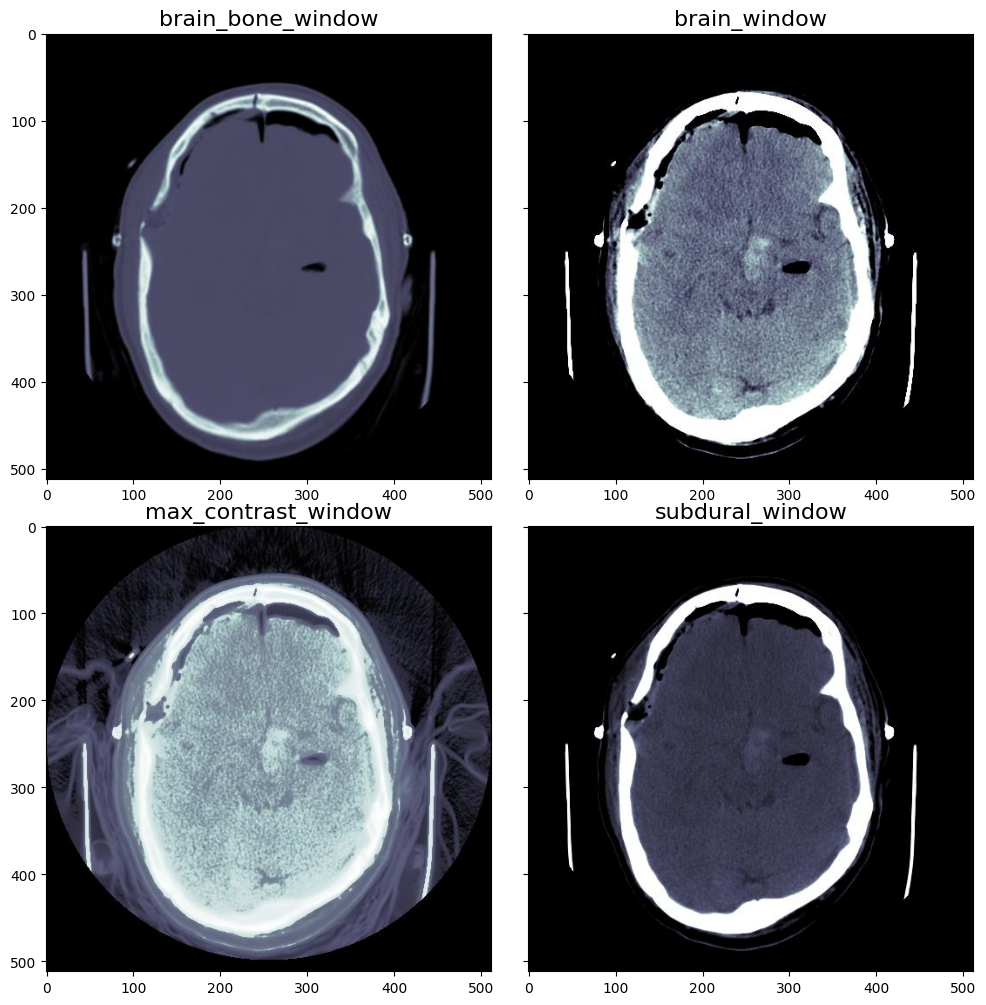

In [49]:
epidural = 'epidural/'
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'

image_types = [(brain_bone, 0), (brain_w, 1), (max_con, 2), (subdural, 3)]

images = [mpimg.imread(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  brain_w + '/ID_0a3f30540.jpg'),
          mpimg.imread(file_dir + epidural +  max_con + '/ID_0a3f30540.jpg'),
         mpimg.imread(file_dir + epidural +  subdural + '/ID_0a3f30540.jpg')]

print(file_dir + epidural + brain_bone + '/ID_0a3f30540.jpg')

f, axes = plt.subplots(2, 2, sharey = True)
f.set_size_inches(10,10)
f.tight_layout()

axes = axes.reshape(4)

for i, j in zip(images, image_types):
    axes[j[1]].imshow(i)
    axes[j[1]].set_title(j[0], fontsize=16)


### Loading and Cleaning the Segmentation Files

In [50]:
#### Rename files for easiser processing -> ex. epidural.csv ###

In [51]:
# local directory of images
file_dir = '../XN_Files/'


#image types
brain_bone = 'brain_bone_window'
brain_w = 'brain_window'
max_con = 'max_contrast_window'
subdural = 'subdural_window'


#image size
im_size = 512*512

In [74]:
def load_labels(f_dir: str, image_type: str) -> pd.DataFrame:
    """Function to get hemmorhage labels. Method prerequisite: rename result csv files to match type_labels dict -> ex. epidural.csv, multi.csv"""
    # set class designations and relevant columns
    type_labels = {'epidural': 1, 'intraparenchymal': 2, 'subarachnoid': 3, 'subdural': 4, 'multi': 5,}
    column_names = ["Origin","Labeling State","All Labels","Majority Label", "Correct Label"]
    labels = pd.DataFrame()
    
    # for each hemorrhage type, load label data
    for k,v in type_labels.items():
        temp_data = pd.read_csv(file_dir + './Hemorrhage Segmentation Project/' + k + '.csv')
        temp_data = temp_data[column_names]
        temp_data['Hemorrhage Type'] = k
        temp_data['Class'] = v
        labels = pd.concat([labels, temp_data])
        
    # drop all rows that are not labeled
    labeled = labels[labels['Labeling State']=='Labeled']
    gold = labels[labels['Labeling State']=='Gold Standard']
    final_labels = pd.concat([labeled, gold]).dropna().reset_index().drop(['index'],axis = 1)
    
    # filter labeled images - only take images which hold correct labels
    final_labels['Correct_Present'] = final_labels['Correct Label'].apply(lambda x: 1 if "x" in x else 0)    
    final_labels = final_labels[final_labels.Correct_Present==1].reset_index().drop(['index','Correct_Present'],axis = 1)

    
    
    # add normal sample
    normal_sample_size = 500
    normal_images = os.listdir(file_dir + 'normal/' + image_type + '/')
    random.seed(123)
    normal_sample = random.sample(normal_images, k=normal_sample_size)
    norm_df = pd.DataFrame(normal_sample, columns=['Origin'])
    norm_df = norm_df.assign(**{ x : 'NA' for x in column_names[1:] })
    norm_df['Hemorrhage Type'] = 'normal'
    norm_df['Class'] = 6
    
    #final df
    final_labels = pd.concat([final_labels, norm_df]).reset_index().drop(['index',],axis = 1)
    final_labels['Image Type'] = image_type
    
    
    return final_labels

In [75]:
# load label data, specify brain_bone_window
labels = load_labels(file_dir, brain_bone)
labels

/var/folders/7t/3srvl3rx4fl_ywrtcrwk4q6rz8g73f/T/ipykernel_59556/918744259.py:10: DtypeWarning: Columns (0,5,6,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,2

,Origin,Labeling State,All Labels,Majority Label,Correct Label,Hemorrhage Type,Class,Image Type
0,ID_004c4b319.jpg,Labeled,"['[{""x"": 0.40818718, ""y"": 0.8623607}, {""x"": 0....","[{""x"": 0.537109375, ""y"": 0.89453125}, {""x"": 0....","[[{'x': 0.537109375, 'y': 0.89453125}, {'x': 0...",epidural,1,brain_bone_window
1,ID_02e2d273d.jpg,Labeled,"['[{""x"": 0.35205495, ""y"": 0.34680602}, {""x"": 0...","[{""x"": 0.46484375, ""y"": 0.357421875}, {""x"": 0....","[[{'x': 0.46484375, 'y': 0.357421875}, {'x': 0...",epidural,1,brain_bone_window
2,ID_03c6a01ca.jpg,Labeled,"['[{""x"": 0.55595756, ""y"": 0.7275065}, {""x"": 0....","[{""x"": 0.53515625, ""y"": 0.71875}, {""x"": 0.5351...","[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,brain_bone_window
3,ID_03c6a01ca.jpg,Labeled,"['[{""x"": 0.55595756, ""y"": 0.7275065}, {""x"": 0....","[{""x"": 0.625, ""y"": 0.46484375}, {""x"": 0.625, ""...","[[{'x': 0.55078125, 'y': 0.7265625}, {'x': 0.5...",epidural,1,brain_bone_window
4,ID_045196c9f.jpg,Labeled,"['[{""x"": 0.591917, ""y"": 0.7922052}, {""x"": 0.60...","[{""x"": 0.591796875, ""y"": 0.791015625}, {""x"": 0...","[[{'x': 0.591796875, 'y': 0.791015625}, {'x': ...",epidural,1,brain_bone_window
...,...,...,...,...,...,...,...,...
2535,ID_002136e63.jpg,NA,NA,NA,NA,normal,6,brain_bone_window
2536,ID_008c2125f.jpg,NA,NA,NA,NA,normal,6,brain_bone_window
2537,ID_028898832.jpg,NA,NA,NA,NA,normal,6,brain_bone_window
2538,ID_033288e3e.jpg,NA,NA,NA,NA,normal,6,brain_bone_window


In [76]:
# In case we want to examine the data manually
labels.to_excel("data.xlsx", index = False)

In [241]:
def load_data_per_image_type(file_dir: str, labels: pd.DataFrame, im_size: int) -> np.array([]):
    data = np.zeros([labels.shape[0], im_size])
    y = np.zeros([labels.shape[0],]).astype(int)
    print(f'Data Shape: {data.shape}', f'Label Shape: {y.shape}')
    for index, row in labels.iterrows():
        try:
            data[index,:] = np.mean(mpimg.imread(file_dir + row['Hemorrhage Type'] +'/'+ row['Image Type'] + '/' + row['Origin']), axis=2).reshape(-1)
            y[index] = row['Class']
        except Exception as e:
            print(f"Image {row['Origin']} is an incompatible size, skipping")
            continue   
    return data, y

In [246]:
X, y = load_data_per_image_type(file_dir, labels, im_size)

Data Shape: (2581, 262144) Label Shape: (2581,)
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


### Logistic Regression

In [245]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [247]:
# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (2193, 262144), y: (2193,)
Test Data Shape -> X: (388, 262144), y: (388,)


In [248]:
clf = LogisticRegression(solver='lbfgs', max_iter=100)
clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%clf.score(X_test, y_test))

/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Score: 0.585


#### Try all other image types 


we can turn this into a script later on and run in discovery to print scores for each type

In [249]:
# brain window
labels = load_labels(file_dir, brain_w)
X, y = load_data_per_image_type(file_dir, labels, im_size)

Data Shape: (2581, 262144) Label Shape: (2581,)
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [250]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (2193, 262144), y: (2193,)
Test Data Shape -> X: (388, 262144), y: (388,)


In [251]:
clf = LogisticRegression(solver='lbfgs', max_iter=100)
clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%clf.score(X_test, y_test))

/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Score: 0.611


In [252]:
# max_contrast_window
labels = load_labels(file_dir, max_con)
X, y = load_data_per_image_type(file_dir, labels, im_size)

Data Shape: (2581, 262144) Label Shape: (2581,)
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (2193, 262144), y: (2193,)
Test Data Shape -> X: (388, 262144), y: (388,)


In [254]:
clf = LogisticRegression(solver='lbfgs', max_iter=100)
clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%clf.score(X_test, y_test))

/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Score: 0.546


In [255]:
# subdural_window
labels = load_labels(file_dir, subdural)
X, y = load_data_per_image_type(file_dir, labels, im_size)

Data Shape: (2581, 262144) Label Shape: (2581,)
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping
could not broadcast input array from shape (312620,) into shape (262144,)
Image ID_88b0d8b4f.jpg is an incompatible size, skipping


In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print(f'Train Data Shape -> X: {X_train.shape}, y: {y_train.shape}')
print(f'Test Data Shape -> X: {X_test.shape}, y: {y_test.shape}')

Train Data Shape -> X: (2193, 262144), y: (2193,)
Test Data Shape -> X: (388, 262144), y: (388,)


In [257]:
clf = LogisticRegression(solver='lbfgs', max_iter=100)
clf.fit(X_train, y_train)
print("Logistic Regression Score: %.3f"%clf.score(X_test, y_test))

Logistic Regression Score: 0.613


/Users/n0342839/Desktop/Project/grad_school/ML/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
